Make predictions with prophet

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install darts
!pip install plotly

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from darts import TimeSeries
from prophet import Prophet

In [4]:
path = "/content/drive/MyDrive/Hillel_ML_Course/11/hw/T10Y2Y.csv"

In [5]:
#read data
data = pd.read_csv(path)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306 entries, 0 to 1305
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    1306 non-null   object
 1   T10Y2Y  1306 non-null   object
dtypes: object(2)
memory usage: 20.5+ KB


In [7]:
#convert column "DATE" to datetime type
data["DATE"] = pd.to_datetime(data["DATE"])

#convert column "T10Y2Y" to float type
data["T10Y2Y"] = pd.to_numeric(data["T10Y2Y"], errors='coerce')

In [8]:
#let's see info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306 entries, 0 to 1305
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    1306 non-null   datetime64[ns]
 1   T10Y2Y  1252 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 20.5 KB


Column "T10Y2Y" has null values

In [9]:
#how much nan values in "T10Y2Y" column
data.isna().sum()

,0
DATE,0
T10Y2Y,54


In [10]:
#define nan data to variable
data_nan = data[data["T10Y2Y"].isna()]

#check 4 years for similarity
print(data_nan[data_nan["DATE"].dt.year==2020].head()), print(data_nan[data_nan["DATE"].dt.year==2021].head()), \
print(data_nan[data_nan["DATE"].dt.year==2022].head()), print(data_nan[data_nan["DATE"].dt.year==2023].head())

          DATE  T10Y2Y
52  2020-01-01     NaN
65  2020-01-20     NaN
85  2020-02-17     NaN
124 2020-04-10     NaN
155 2020-05-25     NaN
          DATE  T10Y2Y
314 2021-01-01     NaN
325 2021-01-18     NaN
345 2021-02-15     NaN
420 2021-05-31     NaN
445 2021-07-05     NaN
          DATE  T10Y2Y
585 2022-01-17     NaN
610 2022-02-21     NaN
649 2022-04-15     NaN
680 2022-05-30     NaN
695 2022-06-20     NaN
          DATE  T10Y2Y
835 2023-01-02     NaN
845 2023-01-16     NaN
870 2023-02-20     NaN
940 2023-05-29     NaN
955 2023-06-19     NaN


(None, None, None, None)

*we have nan values in Holidays data*

#Data imputation

i'll imput nan from previous date values

In [11]:
#replace nan values to values from previous days
data["T10Y2Y"] = data["T10Y2Y"].fillna(method="ffill")

<ipython-input-11-78a83c3c36fb>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data["T10Y2Y"] = data["T10Y2Y"].fillna(method="ffill")


In [12]:
data.isna().sum()

,0
DATE,0
T10Y2Y,0


# EDA

In [13]:
# let`s print all years
years = np.arange(2019, 2025)

# create plotly figure
fig = go.Figure()

# adding lines
for year in years:
    filtered_data = data[data["DATE"].dt.year == year]
    fig.add_trace(go.Scatter(
        x=filtered_data["DATE"],
        y=filtered_data["T10Y2Y"],
        mode='lines',
        name=f'{year}'
    ))

# optimizing view
fig.update_layout(
    title="Interactive Plot by Year",
    xaxis_title="Date",
    yaxis_title="T10Y2Y",
    hovermode="x unified"  # one cheat(tick) for all x
)

# show graph
fig.show()

from this plot i see most high anomalies in march

#DARTS series

In [14]:
#load from dataframe by column "DATE"
series = TimeSeries.from_dataframe(data, time_col="DATE")

##Forecasting by all period training data

### data split

<Axes: xlabel='DATE'>

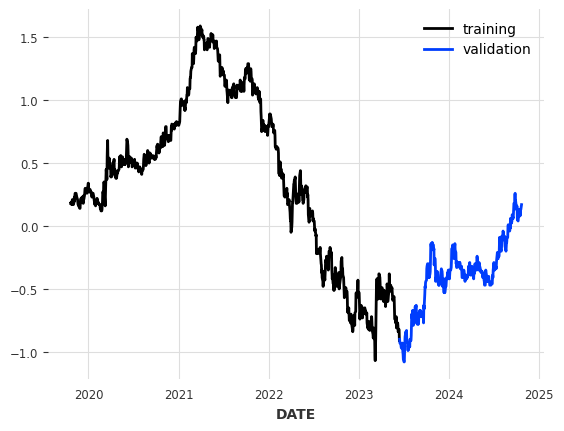

In [15]:
#train validation data split
train, val = series.split_before(pd.Timestamp("2023-06-15"))
train.plot(label="training")
val.plot(label="validation")

### data scale

<Axes: xlabel='DATE'>

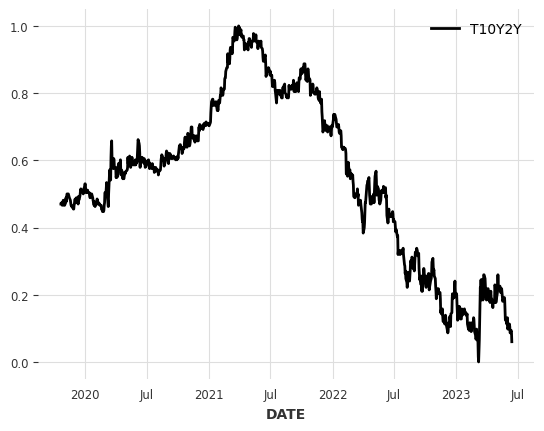

In [16]:
from darts.dataprocessing.transformers import Scaler

scaler = Scaler()
train_scaled = scaler.fit_transform(train)

train_scaled.plot()

(<Axes: xlabel='DATE'>, <Axes: xlabel='DATE'>)

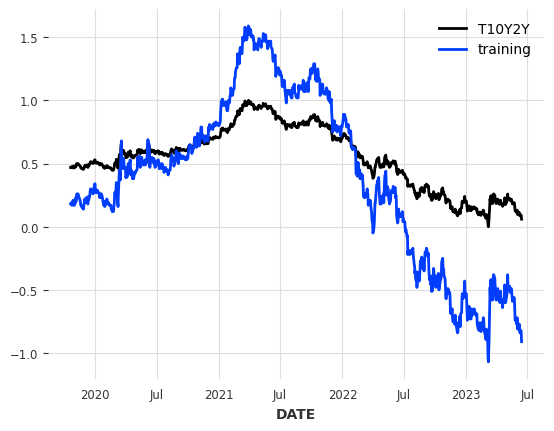

In [17]:
train_scaled.plot(), train.plot(label="training")

###Training by NBEASTModel

In [18]:
from darts.models import NBEATSModel

model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42)

model.fit(train_scaled, epochs=50, verbose=True);

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning:


Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleL

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


###Predict, plot predict

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='DATE'>

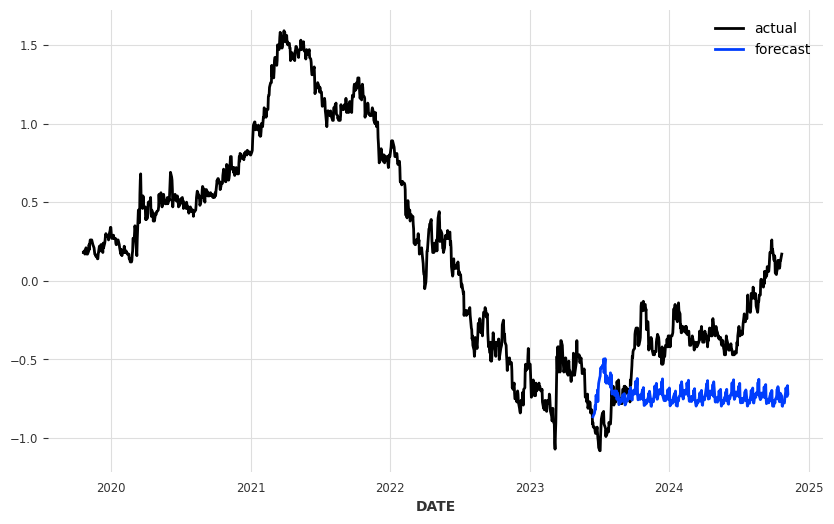

In [20]:
pred_val = model.predict(series=train_scaled, n=365)

# scale back:
pred = scaler.inverse_transform(pred_val)

plt.figure(figsize=(10, 6))
series.plot(label="actual")
pred.plot(label="forecast")


## Forecasting by 2023-2024 year data

In [22]:
#define new data
new_data = data[data["DATE"].dt.year>=2023]

In [24]:
#load from dataframe by column "DATE"
new_series = TimeSeries.from_dataframe(new_data, time_col="DATE")

##Forecasting by 2023-2024 period training data

### data split

<Axes: xlabel='DATE'>

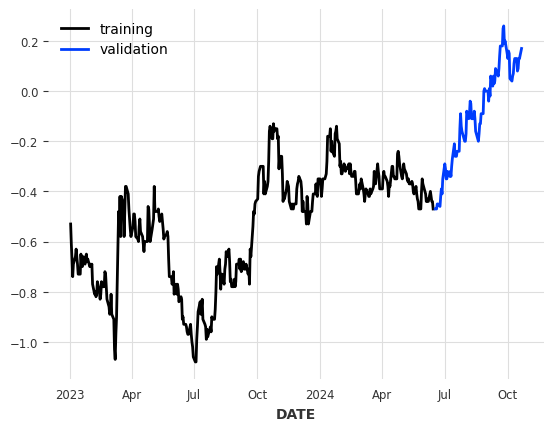

In [26]:
#train validation data split
new_train, new_val = new_series.split_before(pd.Timestamp("2024-06-15"))
new_train.plot(label="training")
new_val.plot(label="validation")

### data scale

<Axes: xlabel='DATE'>

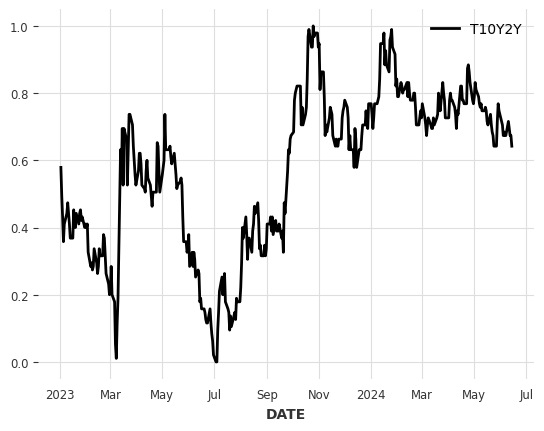

In [27]:
from darts.dataprocessing.transformers import Scaler

scaler = Scaler()
new_train_scaled = scaler.fit_transform(new_train)

new_train_scaled.plot()

(<Axes: xlabel='DATE'>, <Axes: xlabel='DATE'>)

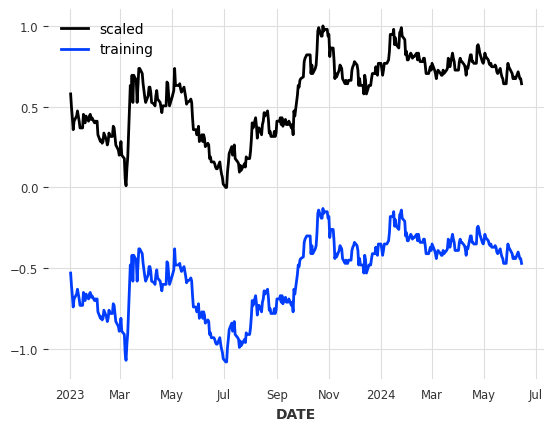

In [29]:
new_train_scaled.plot(label="scaled"), new_train.plot(label="training")

###Training by NBEASTModel

In [30]:
from darts.models import NBEATSModel

model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42)

model.fit(new_train_scaled, epochs=50, verbose=True);

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
-------------------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


###Predict, plot predict

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='DATE'>

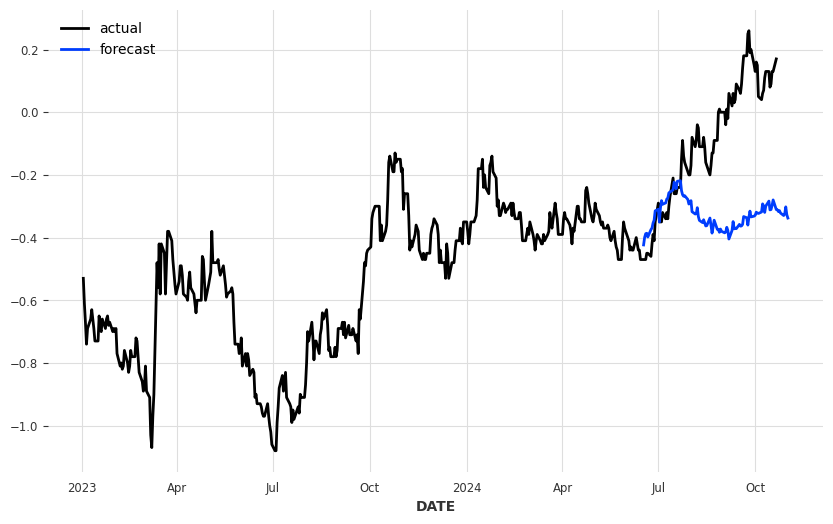

In [38]:
new_pred_val = model.predict(series=new_train_scaled, n=100)

# scale back:
new_pred = scaler.inverse_transform(new_pred_val)

plt.figure(figsize=(10, 6))
new_series.plot(label="actual")
new_pred.plot(label="forecast")



From this graph we can see, that model works on short time predictions

#Prophet

##forecasting by all period training data basemodel

In [46]:
#define new data_frame
prohet_data = data
#change columns names that need model
prohet_data = prohet_data.rename(columns={"DATE":"ds", "T10Y2Y":"y"})

In [47]:
#define prophet model
m = Prophet()

#fir prophet model
m.fit(prohet_data)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph8end9y7/nny7wald.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph8end9y7/fjtqs894.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52591', 'data', 'file=/tmp/tmph8end9y7/nny7wald.json', 'init=/tmp/tmph8end9y7/fjtqs894.json', 'output', 'file=/tmp/tmph8end9y7/prophet_model1gkhjo36/prophet_model-20241024102025.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [49]:
#create future dataframe
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
1666,2025-10-17
1667,2025-10-18
1668,2025-10-19
1669,2025-10-20
1670,2025-10-21


In [50]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1666,2025-10-17,0.624105,0.143536,1.134466
1667,2025-10-18,0.667198,0.157604,1.164975
1668,2025-10-19,0.669494,0.186156,1.178577
1669,2025-10-20,0.633737,0.125639,1.144207
1670,2025-10-21,0.636750,0.154811,1.156224


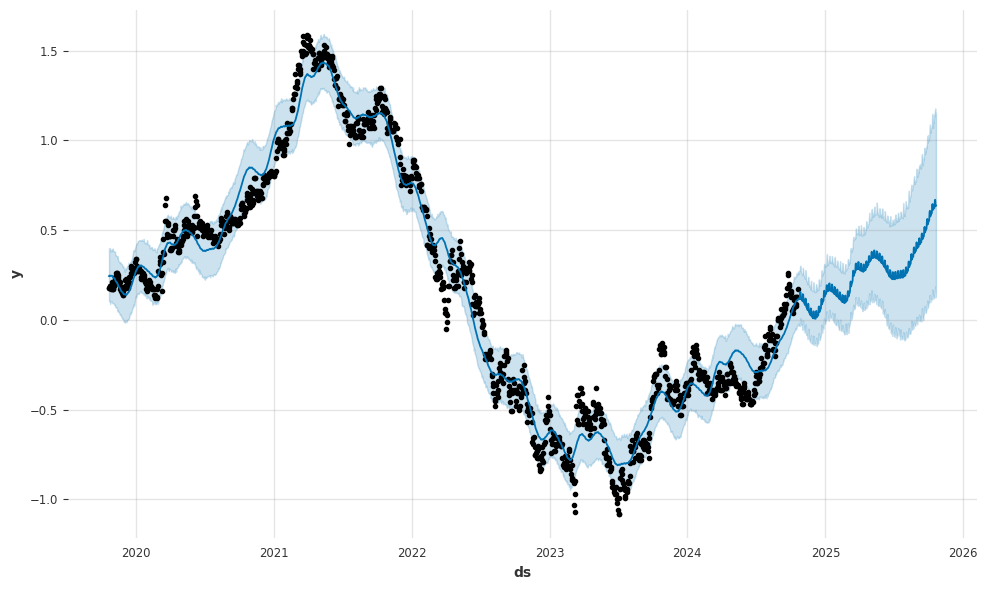

In [51]:
#plot
fig1 = m.plot(forecast)

In [53]:
from prophet.plot import plot_plotly, plot_components_plotly
plot_plotly(m, forecast)

## cross validation

In [54]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')

INFO:prophet:Making 5 forecasts with cutoffs between 2021-11-01 00:00:00 and 2023-10-22 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmph8end9y7/gf4y60sg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph8end9y7/oshisvsn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77725', 'data', 'file=/tmp/tmph8end9y7/gf4y60sg.json', 'init=/tmp/tmph8end9y7/oshisvsn.json', 'output', 'file=/tmp/tmph8end9y7/prophet_modelcykqmk6o/prophet_model-20241024102533.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:25:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:25:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmph8end9y7/0wxounil.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph8end9y7/iwsjdxw4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:546: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:547: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



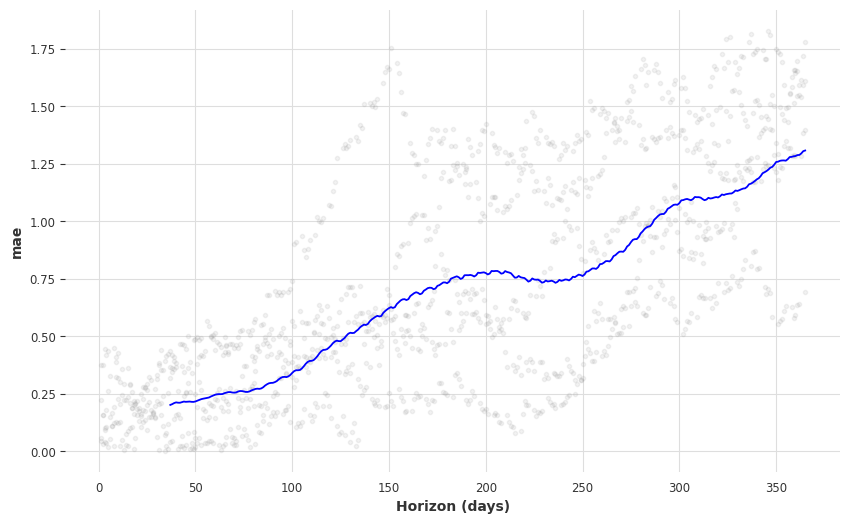

In [58]:
#plot cross validation with mean absolute error
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mae')

# Conclusion

For me prophet looks easer than darts with it baseline and better accuracy on baseline